# Midge preprocessing

This file preprocesses the raw data from the midges
The most important step is interpolation to a fixed sampling rate, to make it more convenient to load data using the data loaders.

In [1]:
import os
from pathlib import Path

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm

In [3]:
from conflab.constants import midge_raw_data_path, midge_data_path, vid2_start

In [4]:
start_dt = vid2_start

In [5]:
# load all midge data
data = {}
for midge_folder in os.listdir(midge_raw_data_path):
    subpath = os.path.join(midge_raw_data_path, midge_folder)
    midge_data = {}
    for f in Path(subpath).rglob('*.csv'):
        df = pd.read_csv(str(f))
        
        df['time'] = pd.to_datetime(df['time'])
        df = df[df['time'] > start_dt].reset_index()
        # convert datetime to seconds
        df['time'] = (df['time'] - df['time'][0]).dt.total_seconds()

        if 'proximity.csv' in str(f):
            k = 'prox'
        elif 'accel.csv' in str(f):
            k = 'accel'
        elif 'gyr.csv' in str(f):
            k = 'gyr'
        elif 'mag.csv' in str(f):
            k = 'mag'
        elif 'rotation.csv' in str(f):
            k = 'rot'
        else:
            pass
        midge_data[k] = df

    data[int(midge_folder)] = midge_data

In [6]:
def interpolate(df: pd.DataFrame, columns, end_time, sr=50):
    x = df['time'].to_numpy()
    y = df[columns].to_numpy()

    fn = interp1d(x, y, axis=0, kind='linear')

    xnew = np.arange(x[0], end_time, 1/sr)

    return pd.DataFrame(fn(xnew), columns=columns)

In [7]:
sample = data[1]['accel'].copy()

In [8]:
interpolated = interpolate(sample, ['time', 'X', 'Y', 'Z'])

TypeError: interpolate() missing 1 required positional argument: 'end_time'

In [ ]:
sample.head(10)

,index,Unnamed: 0,time,X,Y,Z
0,78635,78635,0.000,0.137207,-0.922363,0.414551
1,78636,78636,0.018,0.134277,-0.932129,0.406738
2,78637,78637,0.036,0.143066,-0.913574,0.407715
3,78638,78638,0.054,0.138672,-0.918945,0.425293
4,78639,78639,0.072,0.135254,-0.924805,0.416992
5,78640,78640,0.089,0.123047,-0.920898,0.404785
6,78641,78641,0.106,0.114258,-0.916992,0.397949
7,78642,78642,0.123,0.105957,-0.916016,0.407227
8,78643,78643,0.140,0.115723,-0.930176,0.395996
9,78644,78644,0.157,0.113281,-0.926758,0.427734


In [ ]:
interpolated.head(10)

,time,X,Y,Z
0,0.00,0.137207,-0.922363,0.414551
1,0.02,0.135254,-0.930067,0.406847
2,0.04,0.142090,-0.914768,0.411621
3,0.06,0.137533,-0.920898,0.422526
4,0.08,0.129509,-0.922966,0.411248
5,0.10,0.117360,-0.918371,0.400362
6,0.12,0.107422,-0.916188,0.405589
7,0.14,0.115723,-0.930176,0.395996
8,0.16,0.112161,-0.926413,0.427562
9,0.18,0.111242,-0.922220,0.426585


<AxesSubplot:xlabel='time'>

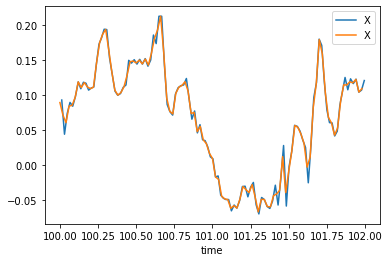

In [ ]:
ax = sample[(sample['time'] >= 100) & (sample['time'] < 102)].plot(x='time', y='X')
interpolated[(interpolated['time'] >= 100) & (interpolated['time'] < 102)].plot(x='time', y='X', ax=ax)

# Interpolate and save

In [10]:
for pid, person_data in tqdm(data.items()):

    end_time = person_data['accel']['time'].iloc[-1] - 10

    accel = interpolate(person_data['accel'], ['time', 'X', 'Y', 'Z'], end_time)
    gyr = interpolate(person_data['gyr'], ['time', 'X', 'Y', 'Z'], end_time)
    mag = interpolate(person_data['mag'], ['time', 'X', 'Y', 'Z'], end_time)
    rot = interpolate(person_data['rot'], ['time', 'a', 'b', 'c', 'd'], end_time)
    prox = interpolate(person_data['prox'], ['time', 'rssi'], end_time)

    joint = pd.concat([accel.iloc[:, :], gyr.iloc[:, 1:], mag.iloc[:, 1:], rot.iloc[:, 1:], prox.iloc[:, 1:]], axis=1)
    joint.columns=[
        'time',
        'accelX', 'accelY', 'accelZ',
        'gyrX', 'gyrY', 'gyrZ',
        'magX', 'magY', 'magZ',
        'rotA', 'rotB', 'rotC', 'rotD',
        'rssi'
    ]
    joint.to_csv(os.path.join(midge_data_path, f'{pid}.csv'), index=False)

  0%|          | 0/49 [00:00<?, ?it/s]

/home/jose/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/jose/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/jose/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/jose/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/jose/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/jose/.local/lib/python3.8/site-packages/scipy/i